## Exercises of day 4

### Exercise 1: Spectrogram plotting function

In this exercise, you will implement your own spectrogram function based on the Kaiser window. The equations to be implemented can be found in the slides on time-frequency analysis.

- If you did not finish the Kaiser window exercise (see slides), complete it so that you can generate a Kaiser window from a specified mainlobe width (in Hz) and sidelobe attenuation (in dB).
- Create an STFT function takes in a signal, window of length N, an overlap percentage (or, alternatively, hop size) between successive windowed segments, number of DFT points used, and the sampling frequency. The function shall return the stft, frequency vector, and time vector.
- Create a function for computing the normalisation factor for the power spectral density (PSD). Optionally, you can also implement the normalisation function for the power spectrum (PS) so that you can easily switch between the two when plotting the spectrogram.
- Combine the above three steps in a function for visualising the spectrogram. Optionally, you can add the time series and Welch PSD/PS estimates as well, allow for dynamic updates of all figures when zooming, etc.. An example is shown below, but feel free to do whatever you think is most suitable.

In [1]:
from kaiser import generate_signal, get_kaiser_shape, get_kaiser_length, stft
from psd import welch, bartlett
from scipy.signal.windows import kaiser
from matplotlib import pyplot as plt
import numpy as np

We generate a signal as a sum of K sinusoids with random weights and frequencies

Frequencies:
[1477.36  387.64 1935.67 2623.06]


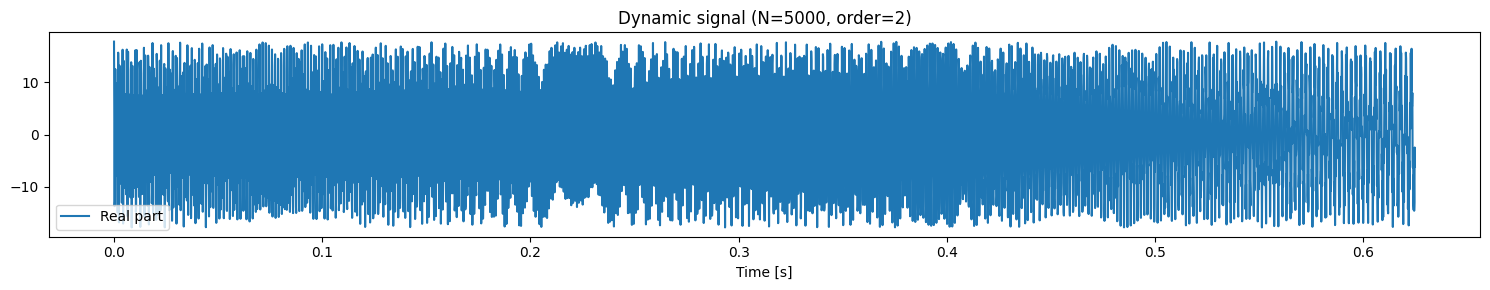

In [2]:
N = 5000 # Length of the signal 
fs = 8000 # Sampling frequency
K = 2

x, fs, f = generate_signal(N, fs, K, plot=True)
print(f'Frequencies:\n{np.round(f, 2)}')
plt.show()


Calculate the kaiser window for given parameters A, Dfw

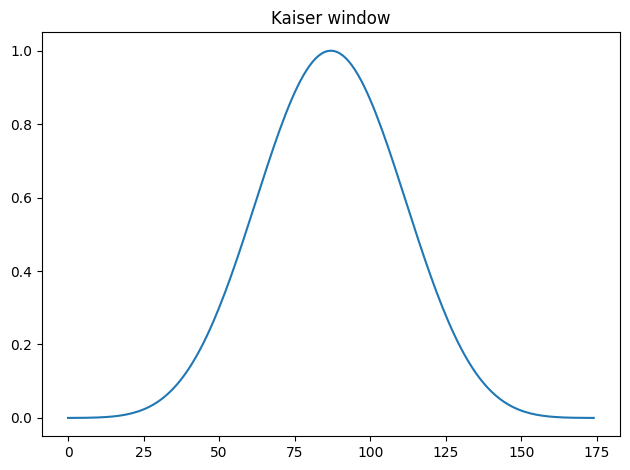

In [3]:
A = 100
Dfw = 200
a = get_kaiser_shape(A)
kaiser_len = get_kaiser_length(Dfw, A, fs)
win = kaiser(kaiser_len, a)

plt.plot(np.arange(len(win)), win)
plt.title('Kaiser window')
plt.tight_layout()
plt.show()

Finally we calculate the spectrogram or stft matrix using the Kaiser window. Restarting the notebook will result
 in a new signal.

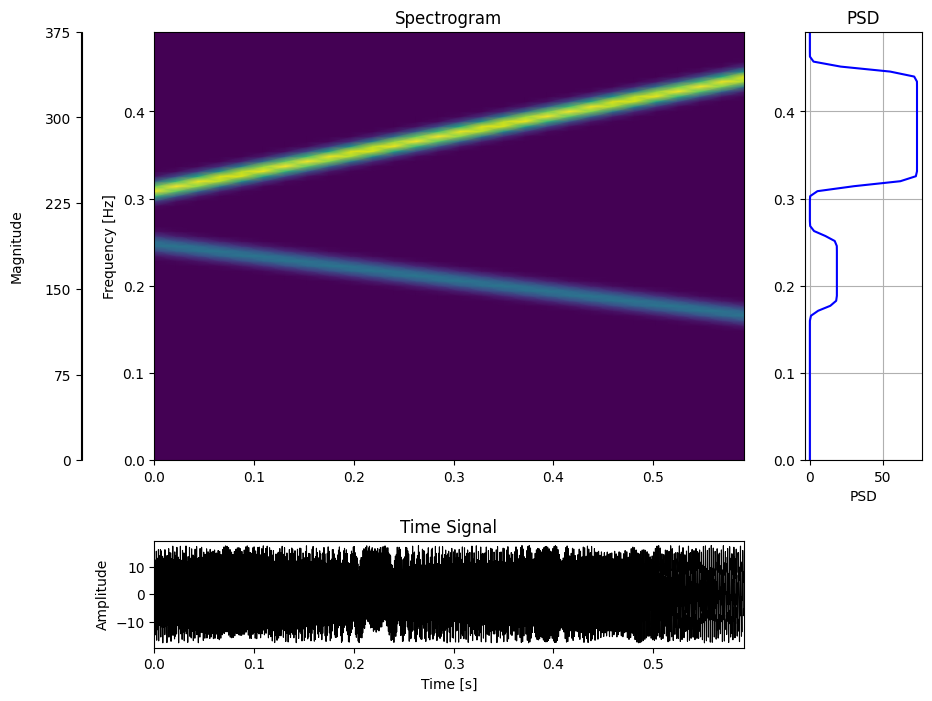

In [4]:
# Calculate the STFT matrix
stft_matrix, f, t = stft(x, fs, win, noverlap=0)
nfft = stft_matrix.shape[0]
spec = np.abs(stft_matrix)[:nfft//2, :]
spec = spec[::-1,:]

# Calculate the PSD
Pxx = welch(x, fs, overlap=0, window=win)

# Calculate the appropriate time axis
times = np.arange(len(x))/fs
idx = np.argmin(np.abs(times - t.max()))
times = times[:idx]


# Plot
fig = plt.figure(figsize=(11, 8))
gs = fig.add_gridspec(2,3, width_ratios=[0.2, 5, 1], height_ratios=[4, 1], hspace=0.3, wspace=0.25)


ax_spec = fig.add_subplot(gs[0,1])
pcm = ax_spec.pcolormesh(t, f[:nfft//2], spec, shading="gouraud")
ax_spec.set_ylabel("Frequency [Hz]")
ax_spec.set_title("Spectrogram")

# dedicated colorbar axis on the left
cax = fig.add_subplot(gs[0,0])
cbar = fig.colorbar(pcm, cax=cax, orientation='vertical')
cbar.set_label("Magnitude", labelpad=15)
cbar.ax.yaxis.set_label_position('left')
cbar.ax.yaxis.tick_left()
cbar.ax.yaxis.set_ticks_position('left')

# set a small number of nicely spaced ticks on the colorbar
ticks = np.linspace(spec.min(), spec.max(), 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.0f}" for t in ticks])
cbar.ax.set_aspect(0.8)  # thinner look

# Time signal (bottom-left)
ax_time = fig.add_subplot(gs[1,1], sharex=ax_spec)
time = np.arange(len(x))/fs
ax_time.plot(times, x[:idx], color="black", linewidth=0.8)
ax_time.set_xlabel("Time [s]")
ax_time.set_ylabel("Amplitude")
ax_time.set_title("Time Signal")

# PSD (right, spans rows)
ax_psd = fig.add_subplot(gs[0,2], sharey=ax_spec)
ax_psd.plot(Pxx[:nfft//2], f[:nfft//2], color="blue")
ax_psd.set_xlabel("PSD")
ax_psd.set_title("PSD")
ax_psd.grid(True)

plt.show()

### Exercise 2: Order tracking function

Implement one of the following two order tracker functions (see slides including references for details):

Velocity synchronous DFT
Second Generation Vold-Kalman filter with a two-pole structural equation

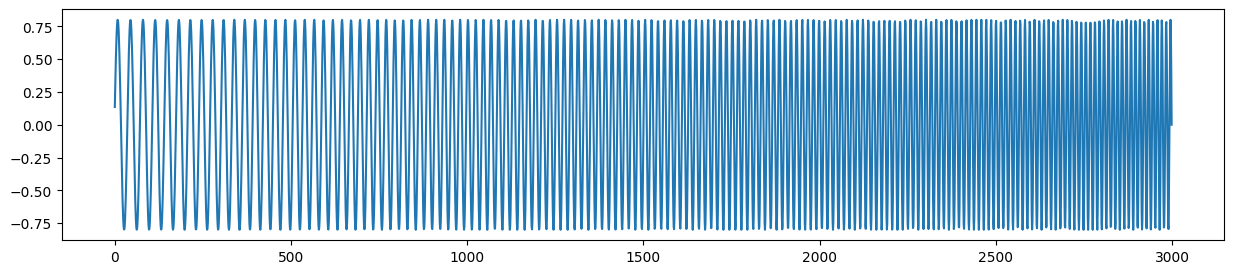

In [ ]:
from vs_dft import generate_order_rpm, vsdft
fs = 8000
N = 3000
rpm_start = 1000
rpm_end = 3000
ord_true = 13
x, _, rpm = generate_order_rpm(N, fs, rpm_start, rpm_end, ord_true)

plt.figure(figsize=(15,3))
plt.plot(np.arange(N), x)
plt.show()

Calculate the VSDFT

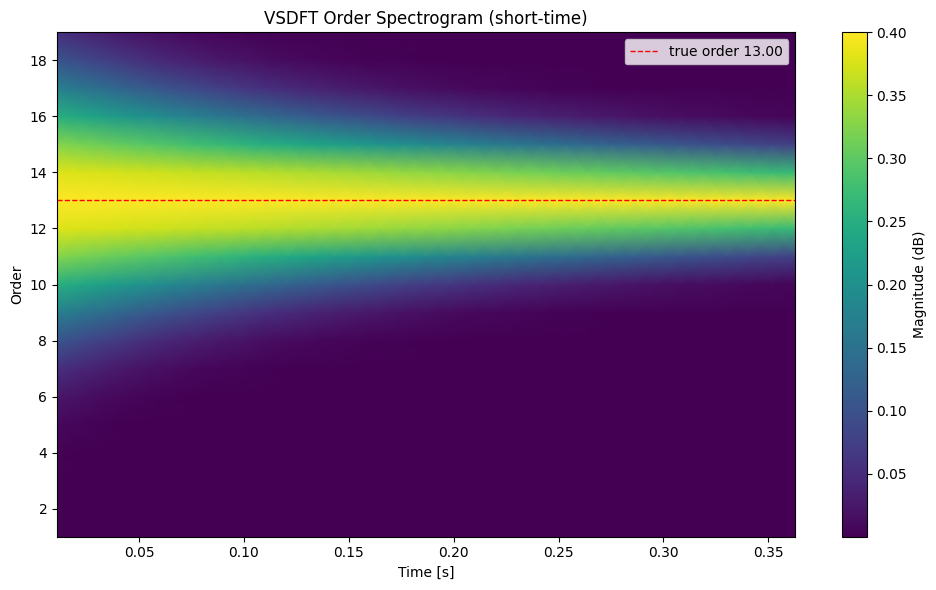

In [17]:
S, times, orders = vsdft(x, fs, np.arange(1,20), rpm, win)

# Plot the order spectrogram
plt.figure(figsize=(10,6))
extent = [times[0], times[-1], orders[0], orders[-1]]
plt.pcolormesh(times, orders, np.abs(S), shading="gouraud")
plt.colorbar(label='Magnitude (dB)')
plt.xlabel("Time [s]")
plt.ylabel("Order")
plt.title("VSDFT Order Spectrogram (short-time)")
plt.axhline(ord_true, color='r', linestyle='--', linewidth=1.0, label=f"true order {ord_true:.2f}")
plt.legend()
plt.tight_layout()
plt.show()

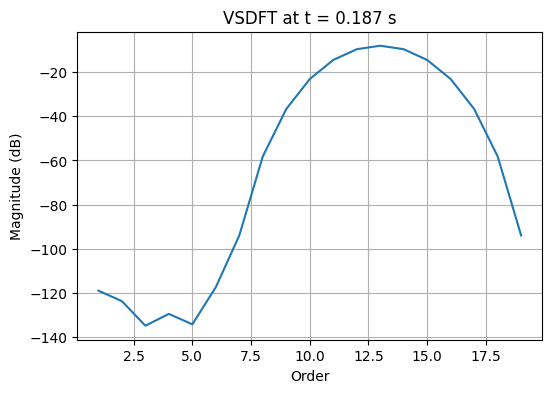

In [18]:
# Single-frame VSDFT at mid-time
mid_idx = len(times)//2
S_mid = S[:, mid_idx]
plt.figure(figsize=(6,4))
plt.plot(orders, 20*np.log10(np.abs(S_mid) + 1e-12))
plt.xlabel("Order")
plt.ylabel("Magnitude (dB)")
plt.title(f"VSDFT at t = {times[mid_idx]:.3f} s")
plt.grid(True)
plt.show()